# **DA5401 ASSIGNMENT-5** 
#### Author: *Vishwanath Vinod* (EE22B002)
#### Date:    4th October 2025

**IMPORTS**

In [90]:
# install imbalanced learning library
# ! pip install imbalanced-learn

import os
import ast
import numpy as np
import pandas as pd
import arff
import xmltodict

from sklearn.manifold import TSNE,Isomap
from matplotlib.colors import ListedColormap
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from sklearn.pipeline import make_pipeline
from sklearn.mixture import GaussianMixture
import matplotlib.patches as mpatches
from imblearn.under_sampling import ClusterCentroids
import seaborn as sns
sns.set_style('dark')

## **A. PREPROCESSING AND INITIAL SETUP**

#### **A.1 DATA LOADING**

Load the feature matrix (103 dimensions) and label matrix (14 dimensions) into dataframes.

In [40]:
arff_path = "yeast.arff"
xml_path  = "yeast.xml"

with open(arff_path, 'r') as f:
    dataset = arff.load(f)

df = pd.DataFrame(dataset['data'], columns=[attr[0] for attr in dataset['attributes']])

with open(xml_path, 'r') as f:
    xml_data = xmltodict.parse(f.read())

labels = xml_data['labels']['label']
label_names = [lbl['@name'] for lbl in labels]

label_df = df[label_names]
feature_df = df.drop(columns=label_names)
label_df[:10]

,Class1,Class2,Class3,Class6,Class4,Class10,Class11,Class5,Class7,Class8,Class9,Class12,Class13,Class14
0,0,0,0,0,0,0,0,0,1,1,0,1,1,0
1,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,1,1,0
3,0,0,1,0,1,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,1,1,0,0,0,0,1,1,0
6,1,0,0,0,0,0,0,0,0,0,0,1,1,0
7,1,0,1,0,1,0,0,0,0,0,0,1,1,0
8,1,1,0,0,0,0,0,0,0,0,0,1,1,0
9,0,0,1,0,1,0,0,0,0,0,0,1,1,0


In [41]:
feature_df[:10]

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0.006166,-0.012976,-0.014259,-0.015024,-0.010747,0.000411,-0.032056,-0.018312,0.030126,0.124722
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0.007680,0.027719,-0.085811,0.111123,0.050541,0.027565,-0.063569,-0.041471,-0.079758,0.017161
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0.096277,-0.044932,-0.089470,-0.009162,-0.012010,0.308378,-0.028053,0.026710,-0.066565,-0.122352
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,-0.083809,0.200354,-0.075716,0.196605,0.152758,-0.028484,-0.074207,-0.089227,-0.049913,-0.043893
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,-0.060467,0.044351,-0.057209,0.028047,0.029661,-0.050026,0.023248,-0.061539,-0.035160,0.067834
5,0.003286,-0.023601,-0.023104,-0.064171,-0.017719,-0.113510,-0.035212,-0.077675,-0.024348,-0.012458,...,-0.200020,-0.052056,0.012218,-0.038346,-0.046463,0.114204,0.125139,-0.012600,0.105835,-0.001440
6,0.076606,-0.025478,0.072419,-0.065383,0.123539,0.120130,0.102248,0.008324,0.094147,-0.014666,...,-0.109926,0.003302,0.024075,0.039718,0.030025,-0.098264,-0.104963,-0.114448,-0.094395,-0.148318
7,-0.106801,-0.069277,-0.132254,-0.099246,-0.188413,-0.110359,-0.155120,-0.168094,-0.182473,0.023208,...,0.185214,-0.084224,-0.123843,0.005166,0.149781,0.099540,-0.145246,-0.030507,-0.160804,-0.045927
8,0.177650,0.136159,0.153211,0.190312,0.158541,0.219521,0.079914,0.232238,0.127932,0.089142,...,-0.017603,-0.026542,0.074257,-0.023072,0.003242,0.252200,-0.029461,-0.026240,0.006896,0.078088
9,0.122075,-0.055828,-0.034775,-0.039235,0.075027,0.087308,0.088062,0.122385,0.091848,-0.099132,...,-0.102717,0.161406,-0.089552,0.077943,-0.093588,-0.016764,-0.069944,-0.105056,-0.080810,0.031019


#### **A.2 DIMENSIONALITY CHECK**

In [42]:
print("Features shape:", feature_df.shape)
print("Labels shape:", label_df.shape)
print("Number of datapoints =", feature_df.shape[0])
print("Number of features =", feature_df.shape[1])
print("Number of labels =", label_df.shape[1])

Features shape: (2417, 103)
Labels shape: (2417, 14)
Number of datapoints = 2417
Number of features = 103
Number of labels = 14


#### **A.3 LABEL SELECTION FOR VISUALIZATION**

In [56]:
def label_name(tup,top_multi,top_single):
    if len(tup) == 1 and tup[0] in top_single:
        return tup[0]
    elif tup in top_multi:
        return "+".join(tup)
    else:
        return "Other"

In [84]:
label_df = label_df.apply(pd.to_numeric, errors="coerce").fillna(0).astype(int)
label_tuples = label_df.apply(lambda row: tuple(label_df.columns[row == 1]), axis=1)

combo_counts = Counter(label_tuples)
most_common = combo_counts.most_common()

single = [c for c in most_common if len(c[0]) == 1]
multi  = [c for c in most_common if len(c[0]) > 1]
print(single)
print(multi)
top_single = [s[0][0] for s in single[:2]]
top_multi  = [m[0] for m in multi[:1]]

print("Top single labels:", top_single)
print("Top multi-label combination:", top_multi)

label_df["label"] = label_tuples.map(lambda tup: label_name(tup, top_multi, top_single))
label_counts = Counter(label_df["label"])
print(label_counts)

[(('Class1',), 32)]
[(('Class3', 'Class4', 'Class12', 'Class13'), 237), (('Class4', 'Class5', 'Class12', 'Class13'), 233), (('Class1', 'Class2', 'Class12', 'Class13'), 172), (('Class1', 'Class2'), 131), (('Class2', 'Class3', 'Class12', 'Class13'), 117), (('Class6', 'Class5', 'Class12', 'Class13'), 105), (('Class7', 'Class8', 'Class12', 'Class13'), 75), (('Class2', 'Class3'), 68), (('Class6', 'Class5', 'Class7', 'Class8', 'Class12', 'Class13'), 60), (('Class1', 'Class12', 'Class13'), 59), (('Class1', 'Class2', 'Class3', 'Class4', 'Class12', 'Class13'), 57), (('Class3', 'Class4'), 53), (('Class2', 'Class3', 'Class4', 'Class12', 'Class13'), 48), (('Class1', 'Class2', 'Class6', 'Class5', 'Class12', 'Class13'), 43), (('Class6', 'Class5'), 39), (('Class12', 'Class13'), 35), (('Class10', 'Class11', 'Class12', 'Class13'), 34), (('Class1', 'Class2', 'Class6', 'Class7', 'Class8', 'Class12', 'Class13'), 31), (('Class10', 'Class11'), 28), (('Class2', 'Class3', 'Class10', 'Class11', 'Class12', 'Cla

**OBSERVATION**

Only one single label type is present in the dataset. So it is not possible to select top 2 single label types. Instead use top 1  single label type and 1 top multi label types.

#### **A.4 Scaling**

If features of a datset are on very different scales (e.g. one feature ranges from 0–1, another from 0–10,000),
then the large-scale features dominate the distance computation, effectively overshadowing smaller-scale ones. Scaling ensures all features contribute equally to the distance metric.

In [85]:
X_scaled = StandardScaler().fit_transform(feature_df)
X = pd.DataFrame(X_scaled, columns=feature_df.columns)
Y = pd.DataFrame(label_df['label'])

## **B. t-SNE AND VERACITY INSPECTION**

In [122]:
X_scaled = X.values
perplexities = [ 5, 15, 30, 50, 60, 80]

y_codes = pd.Categorical(label_df['label'])
y_int = y_codes.codes
label_names = y_codes.categories
colors = sns.color_palette("colorblind", n_colors=10)
colorblind_cmap = ListedColormap(colors)

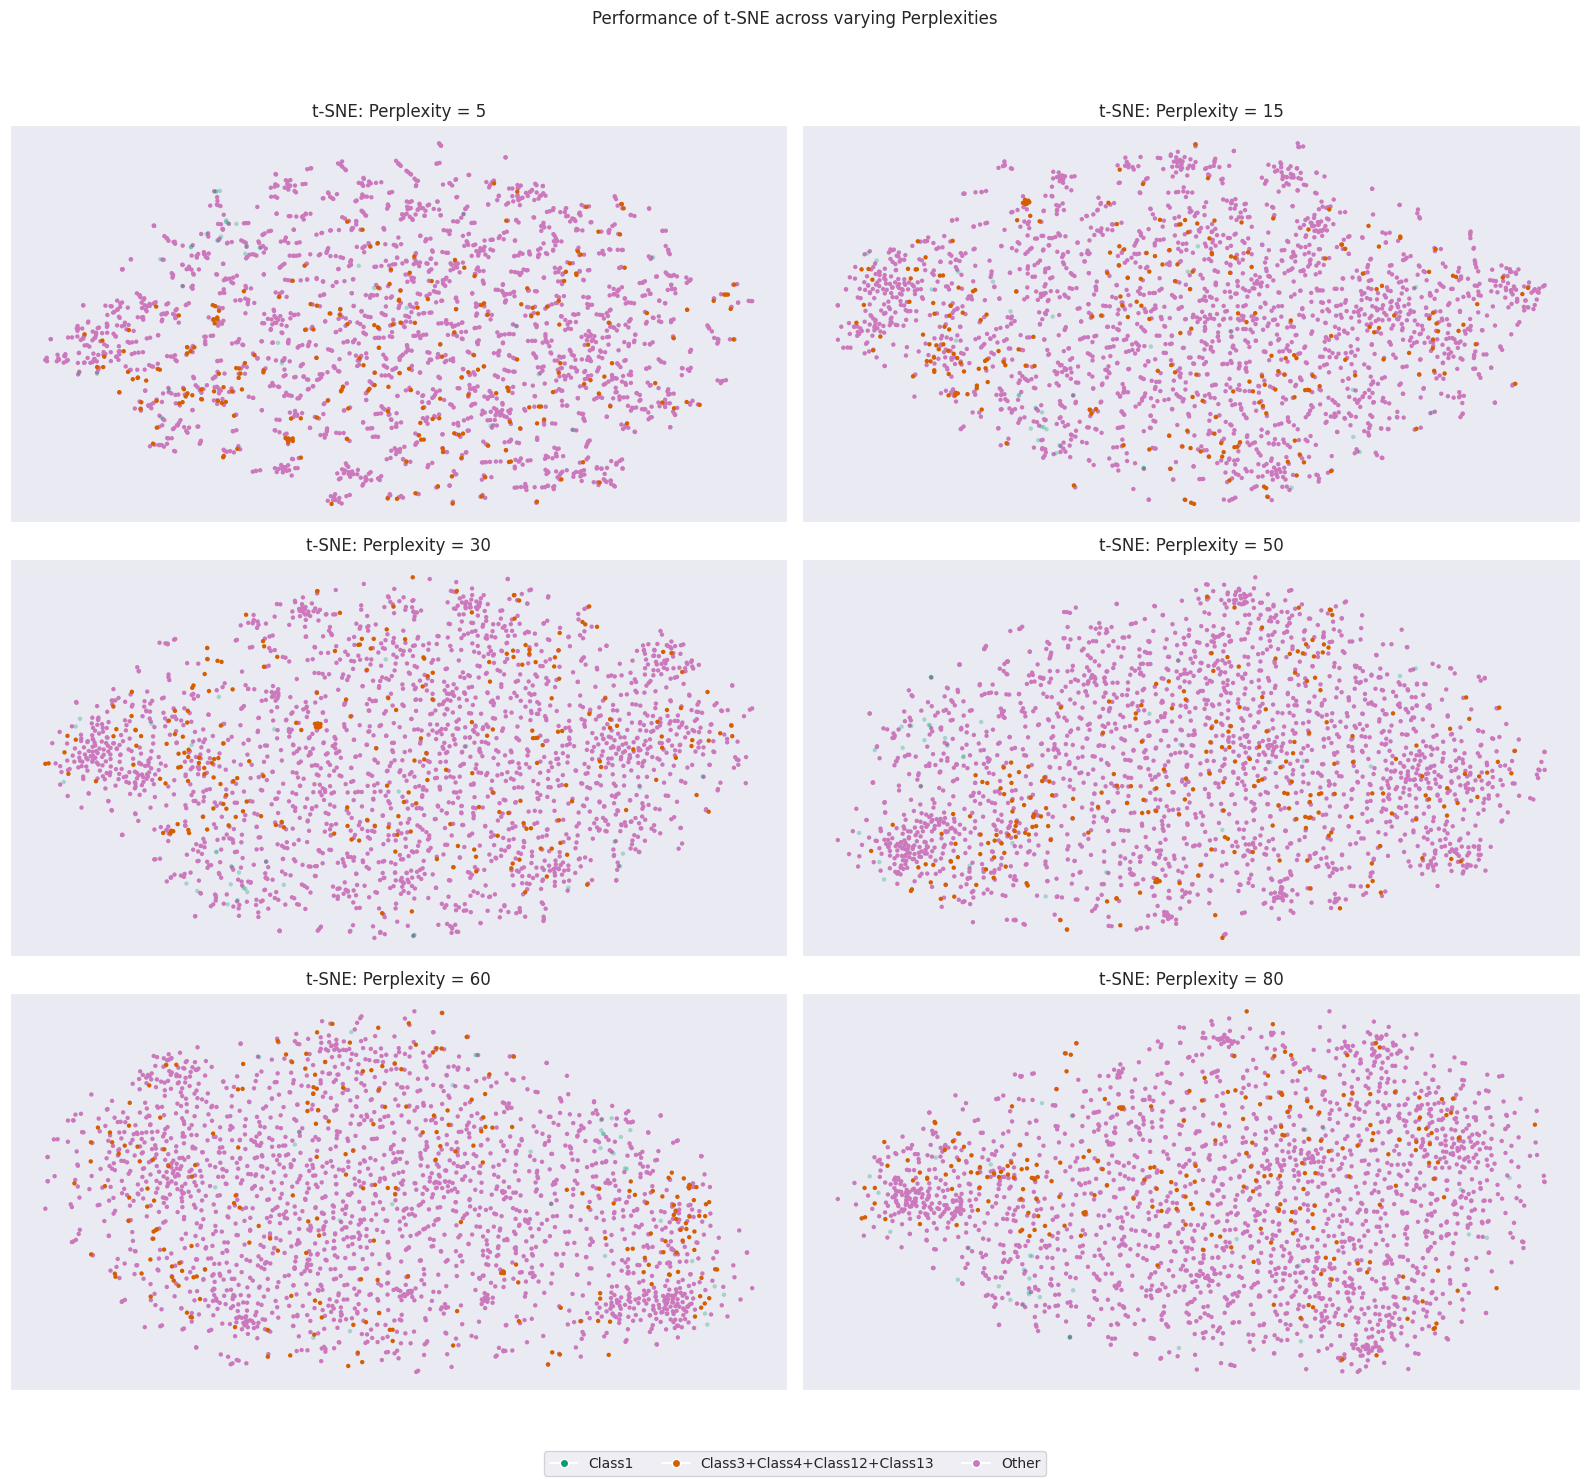

In [124]:
fig, axes = plt.subplots(3, 2, figsize=(16, 15))
axes = axes.flatten()

for i, perp in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
    X_proj = tsne.fit_transform(X_scaled)
    
    for j in reversed(range(len(label_names))):
        mask = y_int == j
        if j==0:
            axes[i].scatter(X_proj[mask, 0], X_proj[mask, 1], c=[colors[j+2]], s=10, alpha=0.3, edgecolors='none')
        else:
            axes[i].scatter(X_proj[mask, 0], X_proj[mask, 1], c=[colors[j+2]], s=10, edgecolors='none')

    axes[i].set_title(f"t-SNE: Perplexity = {perp}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])

handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=colors[i+2], markersize=6)
           for i in range(len(label_names))]
fig.legend(handles, label_names, loc='lower center', ncol=len(label_names))
#fig.subplots_adjust(bottom=0.15, wspace=0.3, hspace=0.3)
fig.suptitle('Performance of t-SNE across varying Perplexities')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # leave space for legend at bottom
plt.show()

**OBSERVATION**

Perplexity roughly controls the “number of effective neighbors” t-SNE considers when positioning points. 

Small values (5,15) focus on local structure (small clusters)

Large values (60,80) captures more global structure, but small clusters may overlap.

Hence we choose an intermediate value of Perplexity=50 for further experiments to best perform t-SNE.

#### **VERACITY INSPECTION**

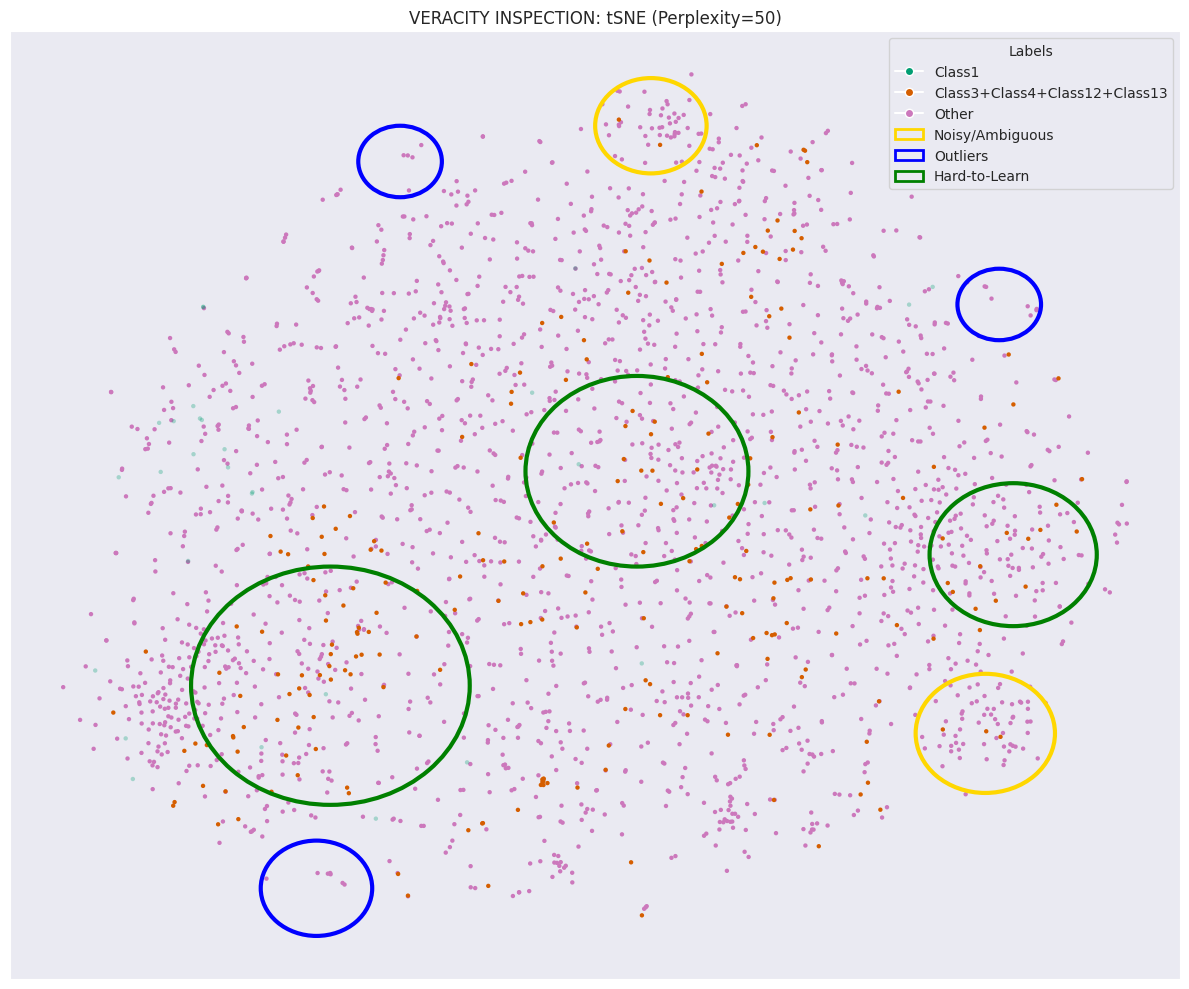

In [169]:
perp = 50
tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
X_proj = tsne.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(12, 10))

# Plot the data
for j in reversed(range(len(label_names))):
    mask = y_int == j
    if j == 0:
        ax.scatter(X_proj[mask, 0], X_proj[mask, 1], c=[colors[j+2]], s=10, alpha=0.3, edgecolors='none')
    else:
        ax.scatter(X_proj[mask, 0], X_proj[mask, 1], c=[colors[j+2]], s=10, edgecolors='none')

# NOISY/AMBIGUOUS - Yellow circles
noisy_regions = [(3,33, 4), (27, -18, 5)]
# OUTLIERS - Blue circles
outlier_regions = [(-21,-31, 4), (28, 18, 3),(-15,30,3)]
# HARD-TO-LEARN - Green circles
hard_regions = [(2, 4, 8),(-20,-14,10),(29,-3,6)]
for x, y, r in noisy_regions:
    circle = mpatches.Circle((x, y), r, fill=False, edgecolor='gold', linewidth=3, label='Noisy/Ambiguous')
    ax.add_patch(circle)
for x, y, r in outlier_regions:
    circle = mpatches.Circle((x, y), r, fill=False, edgecolor='blue', linewidth=3, label='Outliers')
    ax.add_patch(circle)
for x, y, r in hard_regions:
    ellipse = mpatches.Circle((x, y), r, fill=False, edgecolor='green', linewidth=3, label='Hard-to-Learn')
    ax.add_patch(ellipse)

ax.set_title(f"VERACITY INSPECTION: tSNE (Perplexity={perp})")
ax.set_xticks([])
ax.set_yticks([])

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i+2], markersize=6)
           for i in range(len(label_names))]
handles.extend([
    mpatches.Circle((0, 0), 1, fill=False, edgecolor='gold', linewidth=2),
    mpatches.Circle((0, 0), 1, fill=False, edgecolor='blue', linewidth=2),
    mpatches.Circle((0, 0), 1, fill=False, edgecolor='green', linewidth=2)
])
labels = list(label_names) + ['Noisy/Ambiguous', 'Outliers', 'Hard-to-Learn']
ax.legend(handles, labels, loc='best', title='Labels')

plt.tight_layout()
plt.savefig('tsne_annotated.png', dpi=300, bbox_inches='tight')
plt.show()

**1. NOISY/AMBIGUOUS LABELS** (Yellow Circle)

 Points where one color is deeply embedded within a cluster of a different color. Some examples are shown in the figure.

**2. OUTLIERS** (Blue Circle)

Isolated points or tiny, distant clusters.

*Hypotheses:*

- Underrepresented subgroups: These points may come from a rare subpopulation that has very few examples in the dataset, making them appear as outliers when they're actually valid but sparse.

- t-SNE projection distortion: t-SNE can sometimes push dissimilar points to the periphery, exaggerating their distance from the main distribution even if they're not true outliers in the high-dimensional space

**3. HARD-to-LEARN SAMPLES** (Green Circle)

Areas where functional category colors are thoroughly mixed.

*Why simple classifiers struggle?*

- No Linear Separability
Classes are interleaved - no straight line can separate orange from pink from purple without cutting through clusters of the same class.
- Overlapping Features
Genes in mixed regions have nearly identical expression profiles despite different labels. The features provide no discriminative information.

## **C. ISOMAP and MANIFOLD LEARNING**

**DATA MANIFOLD**

In high-dimensional spaces, the data often doesn’t occupy the entire space randomly rather it lies on a lower-dimensional manifold — a smooth, continuous surface embedded in the high-dimensional space. *Manifold learning algorithms* are a class of unsupervised estimators that seek to describe datasets as low-dimensional manifolds embedded in high-dimensional spaces.

Ex:  A sheet of paper is a two-dimensional manifold that exists in three dimensions.
 Even if the paper is bent or curled (a nonlinear embedding) it remains the same two-dimensional manifold, as its intrinsic geometry does not change. 
 
 Manifold learning aims to recover this underlying low-dimensional structure from data that may appear highly contorted in high-dimensional space.

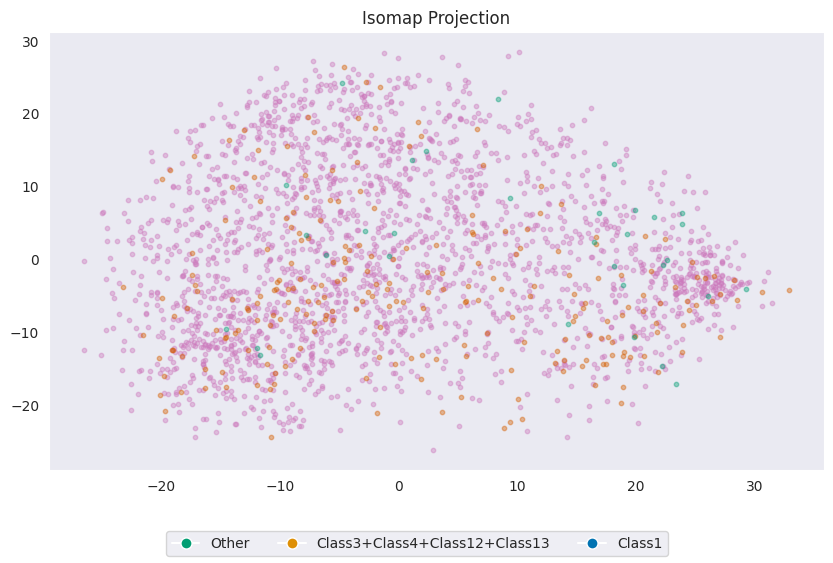

In [113]:
model = Isomap(n_components=2)
proj = model.fit_transform(X_scaled)

fig = plt.figure(figsize=(10, 6))

for i in reversed(range(len(label_names))):
    mask = y_int == i
    plt.scatter(proj[mask, 0], proj[mask, 1], c=[colors[i+2]], s=10, label=label_names[i],alpha=0.4)

plt.title('Isomap Projection')

handles = [plt.Line2D([0], [0], marker='o', color='w', 
                      markerfacecolor=colors[i], markersize=8)
           for i in range(len(label_names))]
fig.legend(handles[::-1], label_names[::-1], loc='lower center', ncol=len(label_names))
fig.subplots_adjust(bottom=0.15, wspace=0.3, hspace=0.3)
plt.show()

#### **OBSERVATIONS**

**1. COMPLEXITY OF MANIFOLD**

The Isomap embedding shows that the data points are spread continuously across the space without forming clearly separable clusters, indicating that the underlying manifold is nonlinear, rather than flat (linearly separable) .

The overlapping regions and the continuous, tangled structure suggest that the manifold is complex, meaning the data lies on a highly curved surface within the original high-dimensional space.

**2. CLASSIFICATION TASK DIFFICULTY**

A complex or highly curved manifold implies that the relationship between features and labels is non-linear, making the classification problem more challenging. Greater the curvature and complexity of the manifold, the harder the classification task, because the decision boundaries must follow intricate, curved paths through the feature space.

Linear classifiers (like logistic regression or linear SVMs) will struggle, since no straight boundary can easily separate the classes in this space. More expressive models (like neural networks) are required to capture the nonlinear boundaries defined by the manifold.

## **D. t-SNE vs ISOMAP**

**Isomap**

1. Builds a k-nearest neighbors graph from the data and computes geodesic distances (shortest paths along the manifold) between all points. It then uses classical Multidimensional Scaling (MDS) to embed the points in lower dimensions such that the geodesic distances are preserved.

2. Captures overall shape or manifold of the data maintaining the relationships between distant points.

3. Good for unfolding nonlinear manifolds where global distances matter.

**t-SNE**

1. Converts pairwise distances into probabilities representing similarity between points. Embeds points in lower dimensions by minimizing the KL divergence between high-dimensional and low-dimensional similarity distributions.

2. Focuses on keeping nearby points close together in the embedding. Captures local clusters and fine structure, often revealing patterns or groups. Excellent for visualizing clusters in high-dimensional data.

3. May distort global distances clusters may appear arbitrarily far apart.

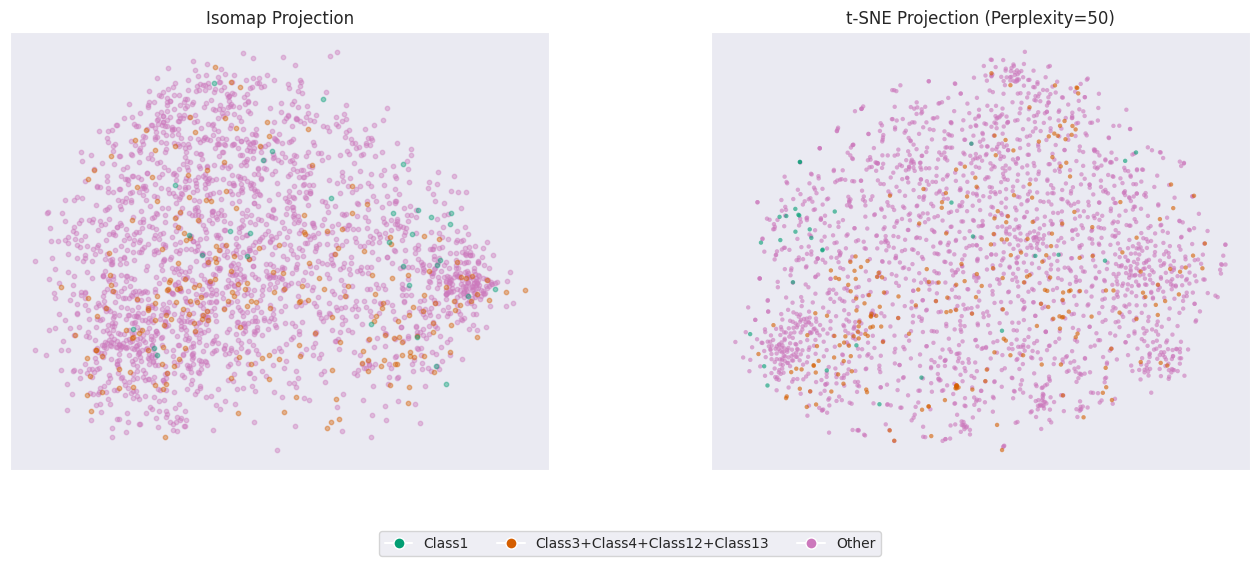

In [126]:
isomap_model = Isomap(n_components=2)
proj_isomap = isomap_model.fit_transform(X_scaled)

tsne_model = TSNE(n_components=2, perplexity=50, random_state=42)
proj_tsne = tsne_model.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i in reversed(range(len(label_names))):
    mask = y_int == i
    axes[0].scatter(proj_isomap[mask, 0], proj_isomap[mask, 1], 
                    c=[colors[i+2]], s=10, alpha=0.4, label=label_names[i])
axes[0].set_title("Isomap Projection")
axes[0].set_xticks([])
axes[0].set_yticks([])
for i in reversed(range(len(label_names))):
    mask = y_int == i
    axes[1].scatter(proj_tsne[mask, 0], proj_tsne[mask, 1], 
                    c=[colors[i+2]], s=10, alpha=0.6, edgecolors='none', label=label_names[i])
axes[1].set_title("t-SNE Projection (Perplexity=50)")
axes[1].set_xticks([])
axes[1].set_yticks([])

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i+2], markersize=8)
           for i in range(len(label_names))]
fig.legend(handles, label_names, loc='lower center', ncol=len(label_names))

fig.subplots_adjust(bottom=0.15, wspace=0.3)
plt.show()


Isomap visualization is better at revealing the global structure of the gene expression data, since it preserves the overall manifold geometry (global structure) by keeping the distances between distant points meaningful.

t-SNE focuses on local neighborhoods (cluster-level relationships) and is thus excellent for identifying clusters of similar samples but can distort the overall relationships between clusters as distances between distant points are not meaningful.